# Test GloFASv5: Ebro
***

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

from lisflood_read_plot import *

from lisfloodreservoirs import read_timeseries
from lisfloodreservoirs.models import Camaflood
from lisfloodreservoirs.utils.plots import reservoir_analysis

In [2]:
from lisfloodreservoirs.calibration.camaflood import Camaflood_calibrator_2par

In [ ]:
from lisfloodreservoirs.models import get_model
from lisfloodreservoirs.calibration import read_results #get_calibrator, 

In [154]:
from lisfloodreservoirs.utils.metrics import KGEmod

In [3]:
import spotpy

In [176]:
import yaml

## Configuration

In [4]:
path_glofas = Path('Z:/nahaUsers/casadje/GloFASv5/reservoirs/')

In [5]:
path_resops = Path('Z:/nahaUsers/casadje/datasets/reservoirs/ResOpsES/v3.0')

## Data
### Reservoirs

In [6]:
reservoirs = gpd.read_file(path_glofas / 'tables' / 'ReservoirGlofas+GDW+parameters.shp').set_index('GDW_ID')

### Time series

#### LISFLOOD simulation

In [7]:
path_sim = path_glofas / 'tests' / 'Ebro'

# read simulated time series
timeseries = {
    'inflow': read_tss(
        tss=path_sim / 'qresinlong_term_run.tss',
        xml=path_sim / 'OSLisfloodGloFASv5calibration_v1_testEuropeRunlong_term_run.xml'
    ),
    'outflow': read_tss(
        tss=path_sim / 'qresoutlong_term_run.tss',
        xml=path_sim / 'OSLisfloodGloFASv5calibration_v1_testEuropeRunlong_term_run.xml'
    ),
    'storage': read_tss(
        tss=path_sim / 'resfilllong_term_run.tss',
        xml=path_sim / 'OSLisfloodGloFASv5calibration_v1_testEuropeRunlong_term_run.xml'
    ),
}

# convert columns to integer
gdw_ids = []
for var, ts in timeseries.items():
    ts.columns = ts.columns.astype(int)
gdw_ids = ts.columns

# reorganize by ID
sim_lisflood = {}
for gdw_id in gdw_ids:
    serie_list = []
    for var, df in timeseries.items():
        serie = df[gdw_id]
        serie.name = var
        if var == 'storage':
            cap_cm = reservoirs.loc[gdw_id, 'CAP_MCM'] * 1e6
            serie *= cap_cm
        serie_list.append(serie)
    sim_lisflood[gdw_id] = pd.concat(serie_list, axis=1)

### Observed

In [8]:
# read observed time series
obs = read_timeseries(
    path=path_resops / 'time_series' / 'csv',
    reservoirs=reservoirs.loc[sim_lisflood.keys(), 'GRAND_ID'].astype(int).tolist(),
    variables=['inflow', 'outflow', 'storage']
)
# convert GRAND_ID to GDW_ID 
obs = {reservoirs.loc[reservoirs.GRAND_ID == grand_id].index.item(): ts for grand_id, ts in obs.items()}
# # convert storage to filling
# for gdw_id, ts in obs.items():
#     ts['storage'] /= reservoirs.loc[gdw_id, 'CAP_MCM'] * 1e6

  0%|          | 0/3 [00:00<?, ?it/s]

## Analysis

In [9]:
path_plots = path_sim / 'plots'
path_plots.mkdir(exist_ok=True)

### LISFLOOD calibration

In [10]:
sim_camaflood = {}
for gdw_id in tqdm(gdw_ids, desc='reservoirs'):

    # extract reservoir characteristics
    cap_cm, catch_sm, area_sm = reservoirs.loc[gdw_id, ['CAP_MCM', 'CATCH_SKM', 'AREA_SKM']] * 1e6
    # extract inflow characteristics
    Qmin, Qn, Q100 = reservoirs.loc[gdw_id, ['DISENV_CMS', 'DISAVG_CMS', 'DIS100_CMS']]
    # extract reservoir parameters
    par_Vf, par_Qf = reservoirs.loc[gdw_id, ['flood_stor', 'outflow_fa']]

    # define reservoir limits
    Vf = par_Vf * cap_cm
    Ve = cap_cm * (0.8 + 0.2 * par_Vf)
    Qf = Q100 * par_Qf

    # compare LISFLOOD vs observation
    x_thr = [0.5 * Vf, Vf, Ve, cap_cm]
    y_thr = [0.5 * Qn, Qf, Qf, Qf]
    x1lim = (0, cap_cm)
    reservoir_analysis(
        sim=sim_lisflood[gdw_id],
        obs=obs[gdw_id],
        title=gdw_id,
        x_thr=x_thr,
        y_thr=y_thr,
        x1lim=x1lim,
        labels=['Lisflood', 'observed'],
        save=path_plots / f'{gdw_id}_lisflood_vs_observed.jpg'
    )


reservoirs:   0%|          | 0/3 [00:00<?, ?it/s]

### CaMa-Flood simulation

Simulation of the CaMa-Flood routine with the inflow simulated with the new GloFAS setup.

In [11]:
sim_camaflood = {}
for gdw_id in tqdm(gdw_ids, desc='reservoirs'):

    # extract reservoir characteristics
    cap_cm, catch_sm, area_sm = reservoirs.loc[gdw_id, ['CAP_MCM', 'CATCH_SKM', 'AREA_SKM']] * 1e6
    # extract inflow characteristics
    Qmin, Qn, Q100 = reservoirs.loc[gdw_id, ['DISENV_CMS', 'DISAVG_CMS', 'DIS100_CMS']]
    # extract reservoir parameters
    par_Vf, par_Qf = reservoirs.loc[gdw_id, ['flood_stor', 'outflow_fa']]

    # define reservoir limits
    Vf = par_Vf * cap_cm
    Ve = cap_cm * (0.8 + 0.2 * par_Vf)
    Qf = Q100 * par_Qf

    # declare CaMa-Flood reservoir
    res = Camaflood(
        Vmin=0.5 * Vf,
        Vf=Vf,
        Ve=Ve,
        Vtot=cap_cm,
        Qn=Qn,
        Qf=Qf,
        catchment=catch_sm,
        Atot=area_sm,
        timestep=86400,
    )

    # simulate with Lisflood inflow
    ts = res.simulate(sim_lisflood[gdw_id].inflow)
    # ts.storage /= cap_cm
    sim_camaflood[gdw_id] = ts

    # compare Lisflood vs CaMa-Flood
    x_thr = [0.5 * Vf, Vf, Ve, cap_cm]
    y_thr = [0.5 * Qn, Qf, Qf, Qf]
    x1lim = (0, cap_cm)
    reservoir_analysis(
        sim=sim_lisflood[gdw_id],
        obs=sim_camaflood[gdw_id],
        title=gdw_id,
        x_thr=x_thr,
        x1lim=x1lim,
        y_thr=y_thr,
        labels=['Lisflood', 'CaMa-Flood'],
        save=path_plots / f'{gdw_id}_lisflood_vs_camaflood.jpg'
    )

reservoirs:   0%|          | 0/3 [00:00<?, ?it/s]

timesteps:   0%|          | 0/17897 [00:00<?, ?it/s]

timesteps:   0%|          | 0/17897 [00:00<?, ?it/s]

timesteps:   0%|          | 0/17897 [00:00<?, ?it/s]

### CaMa-Flood calibration

In [198]:
path_calib = path_sim / 'camaflood'
path_calib.mkdir(exist_ok=True)

# sim_camaflood = {}
for gdw_id in tqdm(gdw_ids, desc='reservoirs'):

    # extract reservoir characteristics
    cap_cm, catch_sm, area_sm = reservoirs.loc[gdw_id, ['CAP_MCM', 'CATCH_SKM', 'AREA_SKM']] * 1e6
    # extract inflow characteristics
    Qmin, Qn, Q100 = reservoirs.loc[gdw_id, ['DISENV_CMS', 'DISAVG_CMS', 'DIS100_CMS']]
    # extract reservoir parameters
    par_Vf, par_Qf = reservoirs.loc[gdw_id, ['flood_stor', 'outflow_fa']]

    # define reservoir limits
    Vf = par_Vf * cap_cm
    Ve = cap_cm * (0.8 + 0.2 * par_Vf)
    Qf = Q100 * par_Qf

    # set up the calibrator
    calibrator = Camaflood_calibrator_2par(
        inflow=sim_lisflood[gdw_id].loc[start:end, 'inflow'],
        storage=obs[gdw_id].loc[start:end, 'storage'],
        outflow=obs[gdw_id].loc[start:end, 'outflow'],
        Vmin=max(0, min(0.1 * cap_cm, obs[gdw_id].storage.min())),
        Vtot=cap_cm,
        catchment=catch_sm,
        # Atot=area_sm,
        target=['storage', 'outflow'],
        obj_func=KGEmod,
        spinup=None,
    )

    # define the sampling method
    dbname = f'{path_calib}/{gdw_id}_samples'
    sceua = spotpy.algorithms.sceua(
        calibrator, 
        dbname=dbname, 
        dbformat='csv', 
        # parallel='mpi' if args.parallel else 'seq',
        save_sim=False,
        # seed=42
    )

    # launch calibration
    sceua.sample(
        4000, 
        ngs=8, 
        kstop=3, 
        pcento=0.01, 
        peps=0.1
    )

reservoirs:   0%|          | 0/3 [00:00<?, ?it/s]

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  4000  repetitions
The objective function will be minimized
Starting burn-in sampling...


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\Ebro\camaflood/1407_samples.csv' created.


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

10 of 4000, minimal objective function=1.50157, time remaining: 00:12:43


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

20 of 4000, minimal objective function=1.50022, time remaining: 00:13:12


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

30 of 4000, minimal objective function=1.50022, time remaining: 00:13:25


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

40 of 4000, minimal objective function=1.50022, time remaining: 00:13:27
Burn-in sampling completed...
Starting Complex Evolution...
ComplexEvo loop #1 in progress...


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

60 of 4000, minimal objective function=1.50022, time remaining: 00:12:08


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

73 of 4000, minimal objective function=1.50022, time remaining: 00:12:15


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

95 of 4000, minimal objective function=1.4976, time remaining: 00:11:06


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

118 of 4000, minimal objective function=1.4976, time remaining: 00:10:22


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

ComplexEvo loop #2 in progress...


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

142 of 4000, minimal objective function=1.4976, time remaining: 00:09:54


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

172 of 4000, minimal objective function=1.4976, time remaining: 00:09:45


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

197 of 4000, minimal objective function=1.49444, time remaining: 00:09:28


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

221 of 4000, minimal objective function=1.49444, time remaining: 00:09:13


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

ComplexEvo loop #3 in progress...


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

248 of 4000, minimal objective function=1.49444, time remaining: 00:09:03


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

278 of 4000, minimal objective function=1.49444, time remaining: 00:08:56


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

307 of 4000, minimal objective function=1.49444, time remaining: 00:08:53


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

322 of 4000, minimal objective function=1.49444, time remaining: 00:08:50


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

337 of 4000, minimal objective function=1.49444, time remaining: 00:08:47


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.211358
ComplexEvo loop #4 in progress...


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

364 of 4000, minimal objective function=1.49444, time remaining: 00:08:39


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

379 of 4000, minimal objective function=1.4941, time remaining: 00:08:37


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

396 of 4000, minimal objective function=1.4941, time remaining: 00:08:35


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

411 of 4000, minimal objective function=1.4941, time remaining: 00:08:32


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

438 of 4000, minimal objective function=1.4941, time remaining: 00:08:26


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

465 of 4000, minimal objective function=1.4941, time remaining: 00:08:20
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.022556
ComplexEvo loop #5 in progress...


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

481 of 4000, minimal objective function=1.4941, time remaining: 00:08:18


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

496 of 4000, minimal objective function=1.4941, time remaining: 00:08:16


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

512 of 4000, minimal objective function=1.4941, time remaining: 00:08:16


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

538 of 4000, minimal objective function=1.4941, time remaining: 00:08:10


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

553 of 4000, minimal objective function=1.4941, time remaining: 00:08:08


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

569 of 4000, minimal objective function=1.4941, time remaining: 00:08:05


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

585 of 4000, minimal objective function=1.4941, time remaining: 00:08:03
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.022557
ComplexEvo loop #6 in progress...


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

600 of 4000, minimal objective function=1.4941, time remaining: 00:08:01


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

615 of 4000, minimal objective function=1.4941, time remaining: 00:07:59


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

643 of 4000, minimal objective function=1.49402, time remaining: 00:07:54


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

659 of 4000, minimal objective function=1.49402, time remaining: 00:07:51


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

675 of 4000, minimal objective function=1.49402, time remaining: 00:07:49


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

691 of 4000, minimal objective function=1.49402, time remaining: 00:07:47


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.004952
THE BEST POINT HAS IMPROVED IN LAST 3 LOOPS BY LESS THAN THE USER-SPECIFIED THRESHOLD 0.010000
CONVERGENCY HAS ACHIEVED BASED ON OBJECTIVE FUNCTION CRITERIA!!!
SEARCH WAS STOPPED AT TRIAL NUMBER: 707
NUMBER OF DISCARDED TRIALS: 0
NORMALIZED GEOMETRIC RANGE = 0.858510
THE BEST POINT HAS IMPROVED IN LAST 3 LOOPS BY 0.004952 PERCENT

*** Final SPOTPY summary ***
Total Duration: 99.24 seconds
Total Repetitions: 707
Minimal objective value: 1.49402
Corresponding parameter setting:
alpha: 0.400191
delta: 0.351591
******************************

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  4000  repetitions
The objective function will be minimized
Starting burn-in sampling...


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\Ebro\camaflood/1410_samples.csv' created.


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

9 of 4000, minimal objective function=1.01766, time remaining: 00:14:40


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

19 of 4000, minimal objective function=0.993316, time remaining: 00:14:07


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

29 of 4000, minimal objective function=0.993316, time remaining: 00:13:56


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

39 of 4000, minimal objective function=0.993316, time remaining: 00:13:50


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

Burn-in sampling completed...
Starting Complex Evolution...
ComplexEvo loop #1 in progress...


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

60 of 4000, minimal objective function=0.993316, time remaining: 00:12:23


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

85 of 4000, minimal objective function=0.993316, time remaining: 00:11:06


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

108 of 4000, minimal objective function=0.993316, time remaining: 00:10:20


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

134 of 4000, minimal objective function=0.993316, time remaining: 00:09:52
ComplexEvo loop #2 in progress...


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

150 of 4000, minimal objective function=0.993316, time remaining: 00:09:46


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

176 of 4000, minimal objective function=0.993316, time remaining: 00:09:28


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

198 of 4000, minimal objective function=0.993316, time remaining: 00:09:10


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

223 of 4000, minimal objective function=0.98765, time remaining: 00:08:58


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

ComplexEvo loop #3 in progress...


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

247 of 4000, minimal objective function=0.98765, time remaining: 00:08:52


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

274 of 4000, minimal objective function=0.98765, time remaining: 00:08:45


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

289 of 4000, minimal objective function=0.98765, time remaining: 00:08:42


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

317 of 4000, minimal objective function=0.98765, time remaining: 00:08:36


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

344 of 4000, minimal objective function=0.98765, time remaining: 00:08:30
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.572565
ComplexEvo loop #4 in progress...


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

361 of 4000, minimal objective function=0.98765, time remaining: 00:08:29


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

376 of 4000, minimal objective function=0.98765, time remaining: 00:08:27


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

406 of 4000, minimal objective function=0.98765, time remaining: 00:08:22


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

421 of 4000, minimal objective function=0.98765, time remaining: 00:08:20


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

437 of 4000, minimal objective function=0.98765, time remaining: 00:08:18


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

468 of 4000, minimal objective function=0.98765, time remaining: 00:08:17
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.000000
THE BEST POINT HAS IMPROVED IN LAST 3 LOOPS BY LESS THAN THE USER-SPECIFIED THRESHOLD 0.010000
CONVERGENCY HAS ACHIEVED BASED ON OBJECTIVE FUNCTION CRITERIA!!!
SEARCH WAS STOPPED AT TRIAL NUMBER: 472
NUMBER OF DISCARDED TRIALS: 0
NORMALIZED GEOMETRIC RANGE = 0.828668
THE BEST POINT HAS IMPROVED IN LAST 3 LOOPS BY 0.000000 PERCENT

*** Final SPOTPY summary ***
Total Duration: 66.07 seconds
Total Repetitions: 472
Minimal objective value: 0.98765
Corresponding parameter setting:
alpha: 0.261987
delta: 0.228814
******************************

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  4000  repetitions
The objective function will be minimized
Starting burn-in sampling...


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\Ebro\camaflood/1423_samples.csv' created.


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

10 of 4000, minimal objective function=0.530499, time remaining: 00:12:28


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

20 of 4000, minimal objective function=0.530499, time remaining: 00:13:01


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

30 of 4000, minimal objective function=0.530499, time remaining: 00:13:10


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

40 of 4000, minimal objective function=0.530499, time remaining: 00:13:14
Burn-in sampling completed...
Starting Complex Evolution...
ComplexEvo loop #1 in progress...


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

59 of 4000, minimal objective function=0.530499, time remaining: 00:11:56


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

83 of 4000, minimal objective function=0.530499, time remaining: 00:10:44


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

105 of 4000, minimal objective function=0.530499, time remaining: 00:09:59


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

129 of 4000, minimal objective function=0.530499, time remaining: 00:09:32
ComplexEvo loop #2 in progress...


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

144 of 4000, minimal objective function=0.530499, time remaining: 00:09:26


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

171 of 4000, minimal objective function=0.530499, time remaining: 00:09:13


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

198 of 4000, minimal objective function=0.530499, time remaining: 00:09:03


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

223 of 4000, minimal objective function=0.530499, time remaining: 00:08:52


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

237 of 4000, minimal objective function=0.530499, time remaining: 00:08:54
ComplexEvo loop #3 in progress...


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

264 of 4000, minimal objective function=0.530342, time remaining: 00:08:46


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

290 of 4000, minimal objective function=0.530342, time remaining: 00:08:38


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

316 of 4000, minimal objective function=0.530342, time remaining: 00:08:31


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

342 of 4000, minimal objective function=0.530342, time remaining: 00:08:24
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.029562
ComplexEvo loop #4 in progress...


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

367 of 4000, minimal objective function=0.530342, time remaining: 00:08:18


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

392 of 4000, minimal objective function=0.530342, time remaining: 00:08:11


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

417 of 4000, minimal objective function=0.530342, time remaining: 00:08:05


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

442 of 4000, minimal objective function=0.530342, time remaining: 00:08:00
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.029565
ComplexEvo loop #5 in progress...


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

467 of 4000, minimal objective function=0.529985, time remaining: 00:07:54


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

480 of 4000, minimal objective function=0.529985, time remaining: 00:07:54


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

495 of 4000, minimal objective function=0.529985, time remaining: 00:07:53


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

511 of 4000, minimal objective function=0.529985, time remaining: 00:07:51


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

540 of 4000, minimal objective function=0.529985, time remaining: 00:07:48


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.067243
ComplexEvo loop #6 in progress...


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

567 of 4000, minimal objective function=0.529985, time remaining: 00:07:43


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

582 of 4000, minimal objective function=0.529985, time remaining: 00:07:41


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

597 of 4000, minimal objective function=0.529985, time remaining: 00:07:40


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

625 of 4000, minimal objective function=0.529985, time remaining: 00:07:36


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

648 of 4000, minimal objective function=0.529985, time remaining: 00:07:31


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.067258
ComplexEvo loop #7 in progress...


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

676 of 4000, minimal objective function=0.529985, time remaining: 00:07:27


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

705 of 4000, minimal objective function=0.529985, time remaining: 00:07:23


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

731 of 4000, minimal objective function=0.529985, time remaining: 00:07:21


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

761 of 4000, minimal objective function=0.529985, time remaining: 00:07:17


timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.000000
THE BEST POINT HAS IMPROVED IN LAST 3 LOOPS BY LESS THAN THE USER-SPECIFIED THRESHOLD 0.010000
CONVERGENCY HAS ACHIEVED BASED ON OBJECTIVE FUNCTION CRITERIA!!!
SEARCH WAS STOPPED AT TRIAL NUMBER: 779
NUMBER OF DISCARDED TRIALS: 0
NORMALIZED GEOMETRIC RANGE = 0.712258
THE BEST POINT HAS IMPROVED IN LAST 3 LOOPS BY 0.000000 PERCENT

*** Final SPOTPY summary ***
Total Duration: 104.72 seconds
Total Repetitions: 779
Minimal objective value: 0.529985
Corresponding parameter setting:
alpha: 0.664186
delta: 0.126499
******************************



In [250]:
gdw_id = 1407

In [ ]:
# read calibration results
dbname = f'{path_calib}/{gdw_id}_samples'
results, parameters = read_results(f'{dbname}.csv')

# convert parameter into reservoir attributes
calibrated_attrs = calibrator.pars2attrs(list(parameters.values()))

# declare the reservoir with optimal parameters
reservoir = get_model('camaflood', **calibrated_attrs)

In [260]:
calibrated_attrs

{'Vmin': np.float64(89422734.8125),
 'Vf': np.float64(178845469.625),
 'Ve': np.float64(393289093.925),
 'Vtot': np.float64(446900000.0),
 'Qn': np.float64(34.43693963675213),
 'Qf': 252.37983950901543,
 'catchment': np.float64(2186000000.0)}

In [261]:
# export calibrated parameters
with open(path_calib / f'{gdw_id}_optimal_parameters.yml', 'w') as file:
    yaml.dump(reservoir.get_params(), file)

TypeError: float() argument must be a string or a real number, not 'NoneType'

In [262]:
# simulate the reservoir
Vo = obs[gdw_id].loc[start, 'storage'] #ts.storage.iloc[0]
sim = reservoir.simulate(
    inflow=sim_lisflood[gdw_id].loc[start:end, 'inflow'],
    Vo=None if pd.isna(Vo) else Vo,
)
# sim_cal.to_csv(cfg.PATH_CALIB / f'{grand_id}_simulation.csv', float_format='%.3f')

timesteps:   0%|          | 0/6084 [00:00<?, ?it/s]

1407	k = 0.000


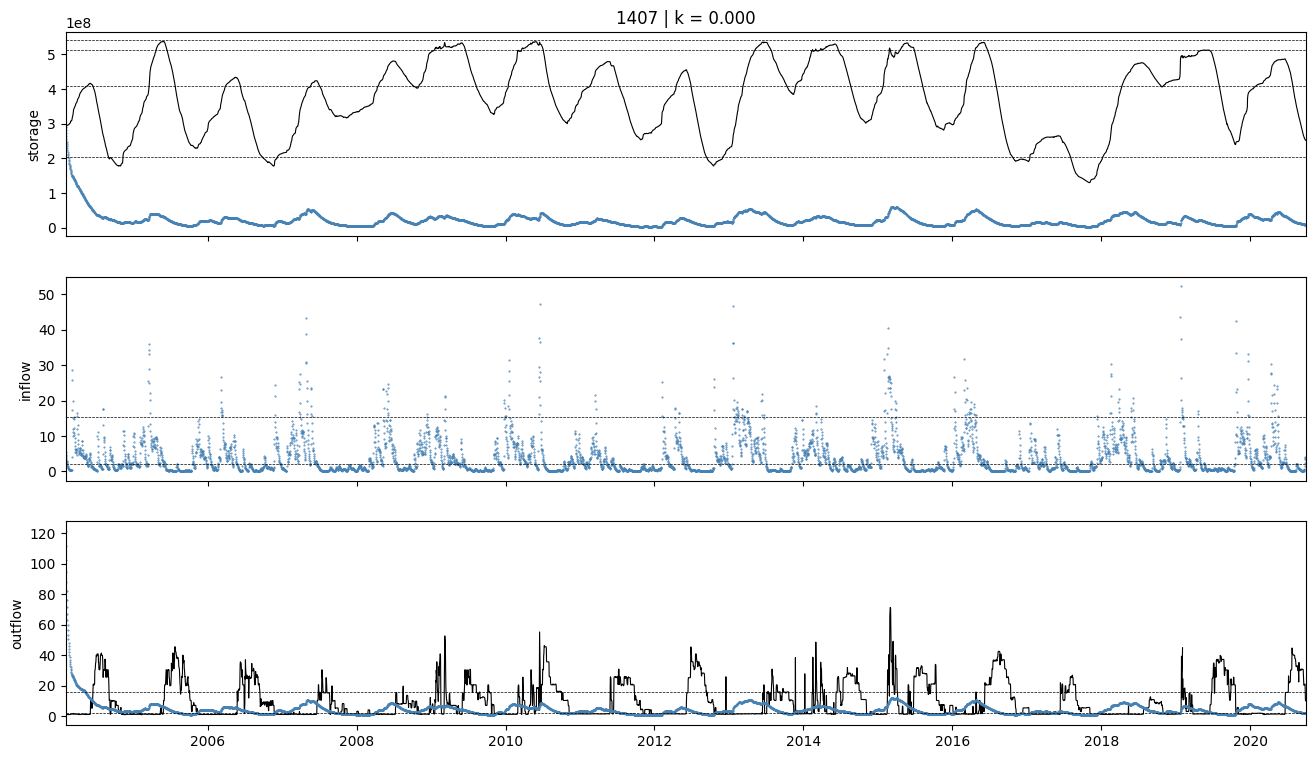

In [263]:
# extract reservoir characteristics
cap_cm, catch_sm, area_sm = reservoirs.loc[gdw_id, ['CAP_MCM', 'CATCH_SKM', 'AREA_SKM']] * 1e6
# extract inflow characteristics
Qmin, Qn, Q100 = reservoirs.loc[gdw_id, ['DISENV_CMS', 'DISAVG_CMS', 'DIS100_CMS']]
# extract reservoir parameters
par_Vf, par_Qf = reservoirs.loc[gdw_id, ['flood_stor', 'outflow_fa']]

k = max(1 - 5 * (cap_cm - Vf) / catch_sm, 0)
print(f'{gdw_id}\tk = {k:.3f}')

# define reservoir limits
Vf = par_Vf * cap_cm
Ve = cap_cm * (0.8 + 0.2 * par_Vf)
Qf = Q100 * par_Qf

year_start, year_end = reservoirs.loc[gdw_id, ['YEAR_DAM', 'REM_YEAR']]

fig, axes = plt.subplots(nrows=3, figsize=(16, 9), sharex=True)

flood_mode = (sim.storage > Vf) & (sim.inflow > Qf)

for ax, var in zip(axes, ['storage', 'inflow', 'outflow']):
    ax.scatter(
        sim[flood_mode].index, 
        sim.loc[flood_mode, var], 
        marker='.', 
        s=.8, 
        color='firebrick')
    ax.scatter(
        sim[~flood_mode].index, 
        sim.loc[~flood_mode, var], 
        marker='.', 
        s=.8, 
        color='steelblue'
    )
    if var in ['storage', 'outflow']:
        ax.plot(obs[gdw_id][var], lw=.8, c='k', zorder=0)
    ax.set_ylabel(var)
    
for y in [0.5 * Vf, Vf, Ve, cap_cm]:
    axes[0].axhline(y, ls='--', c='k', lw=.5)
start = max(datetime(int(year_start), 1, 1), sim.first_valid_index()) if year_start else sim.first_valid_index()
end = min(datetime(int(year_end), 12, 31), sim.last_valid_index()) if year_end else sim.last_valid_index()
ax.set_xlim(start, end)

for y in [0.5 * Qn, Qf]:
    axes[1].axhline(y, ls='--', c='k', lw=.5)
    axes[2].axhline(y, ls='--', c='k', lw=.5)

axes[0].set_title(f'{gdw_id} | k = {k:.3f}');

# plt.savefig(path_plots / f'{gdw_id}_timeseries.jpg', dpi=300, bbox_inches='tight')

<Axes: xlabel='iteration'>

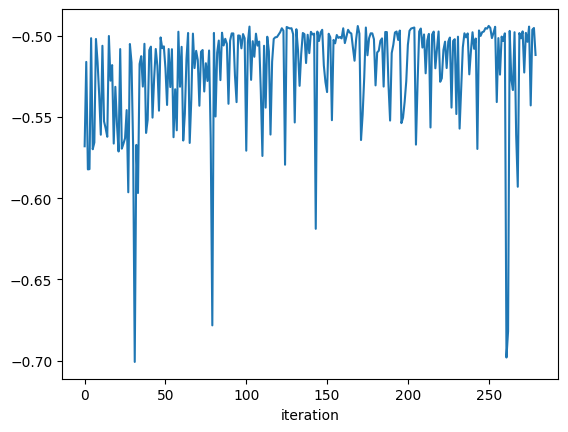

In [265]:
(1 - results.like1).plot()

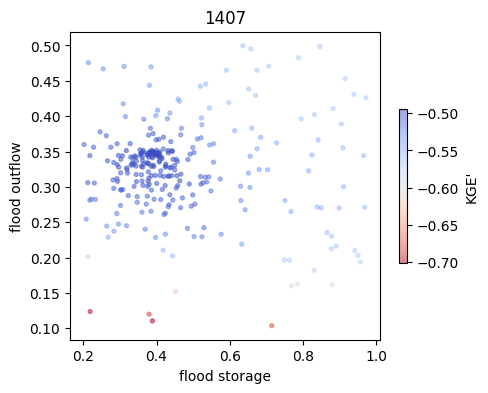

In [267]:
fig, ax = plt.subplots(figsize=(5, 4))
sct = ax.scatter(
    x=results.alpha, 
    y=results.delta, 
    c=(1 - results.like1), 
    s=8,
    cmap='coolwarm_r', 
    alpha=.5,
    # vmin=-1, 
    # vmax=1
)
ax.set(
    xlabel='flood storage',
    ylabel='flood outflow',
    title=gdw_id,
)
plt.colorbar(sct, shrink=.5, label="KGE'");

***

reservoirs:   0%|          | 0/3 [00:00<?, ?it/s]

1407	k = 0.000
1410	k = 0.000
1423	k = 0.773


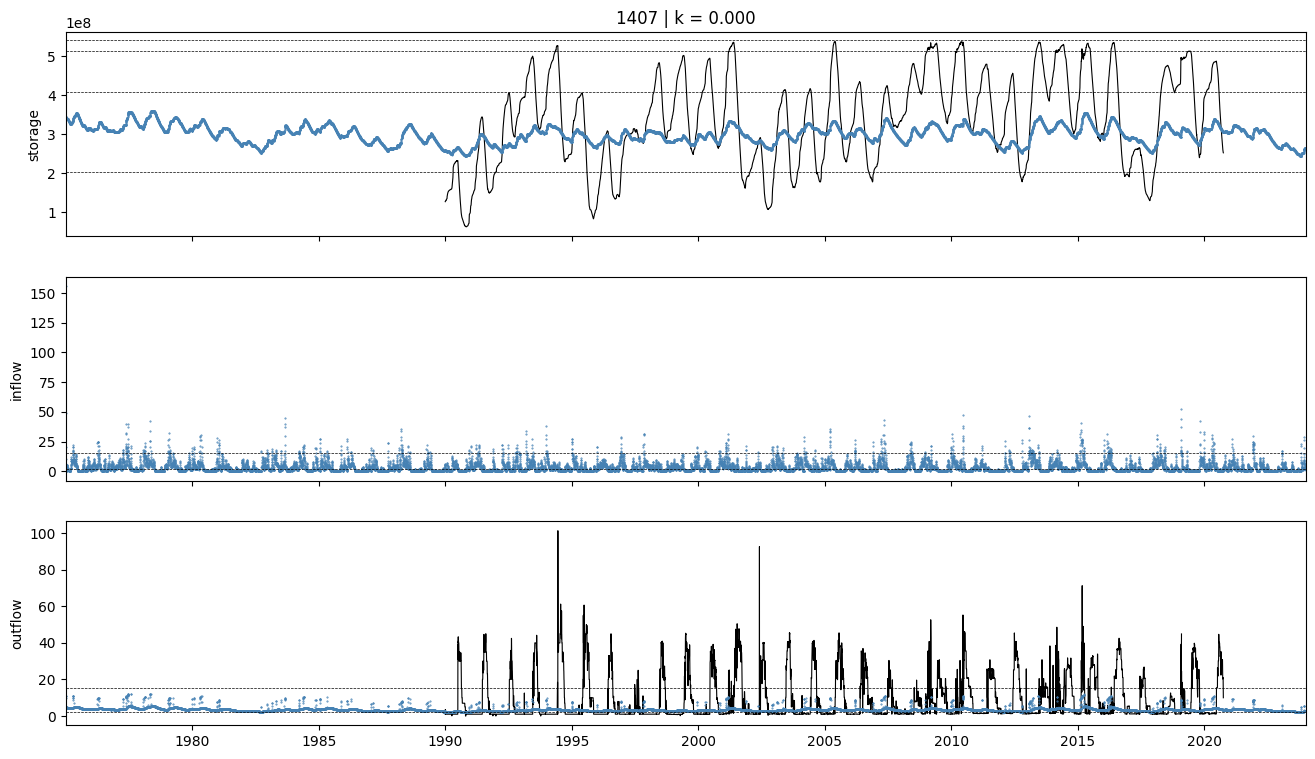

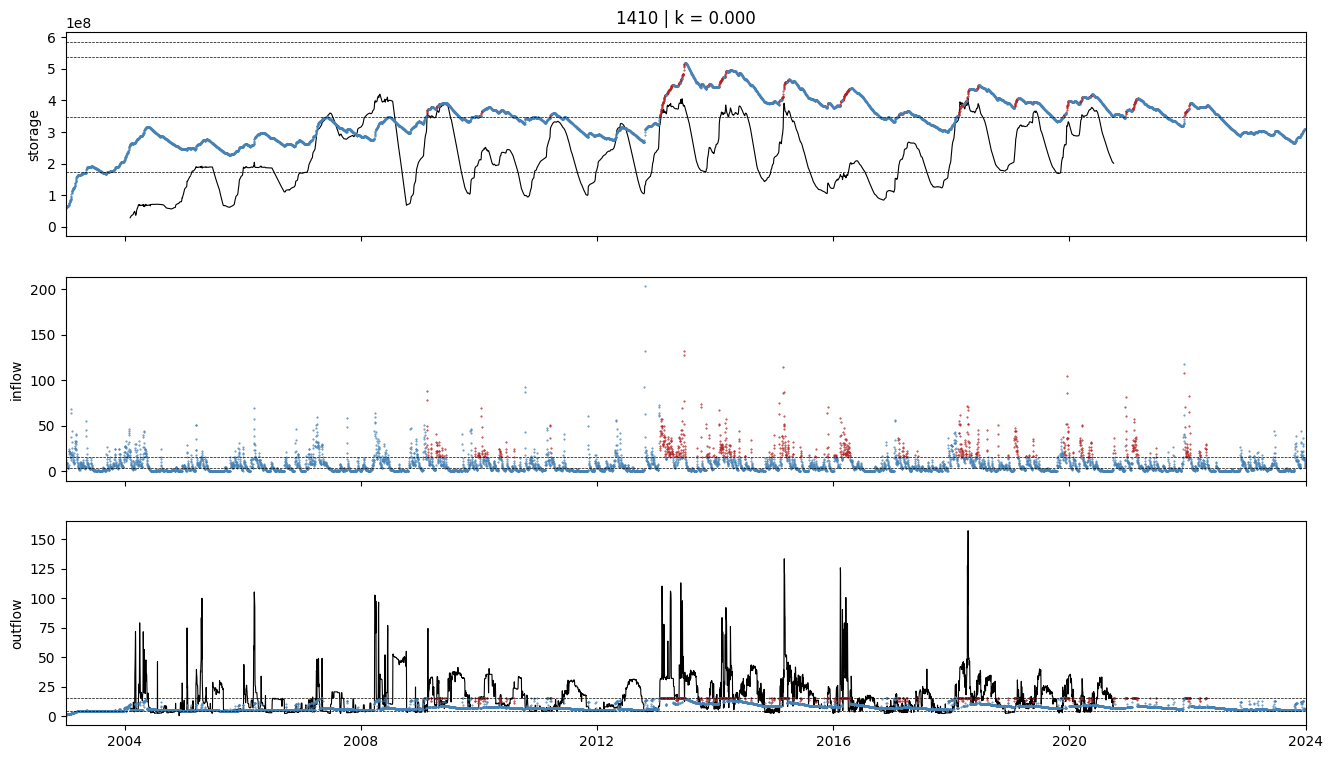

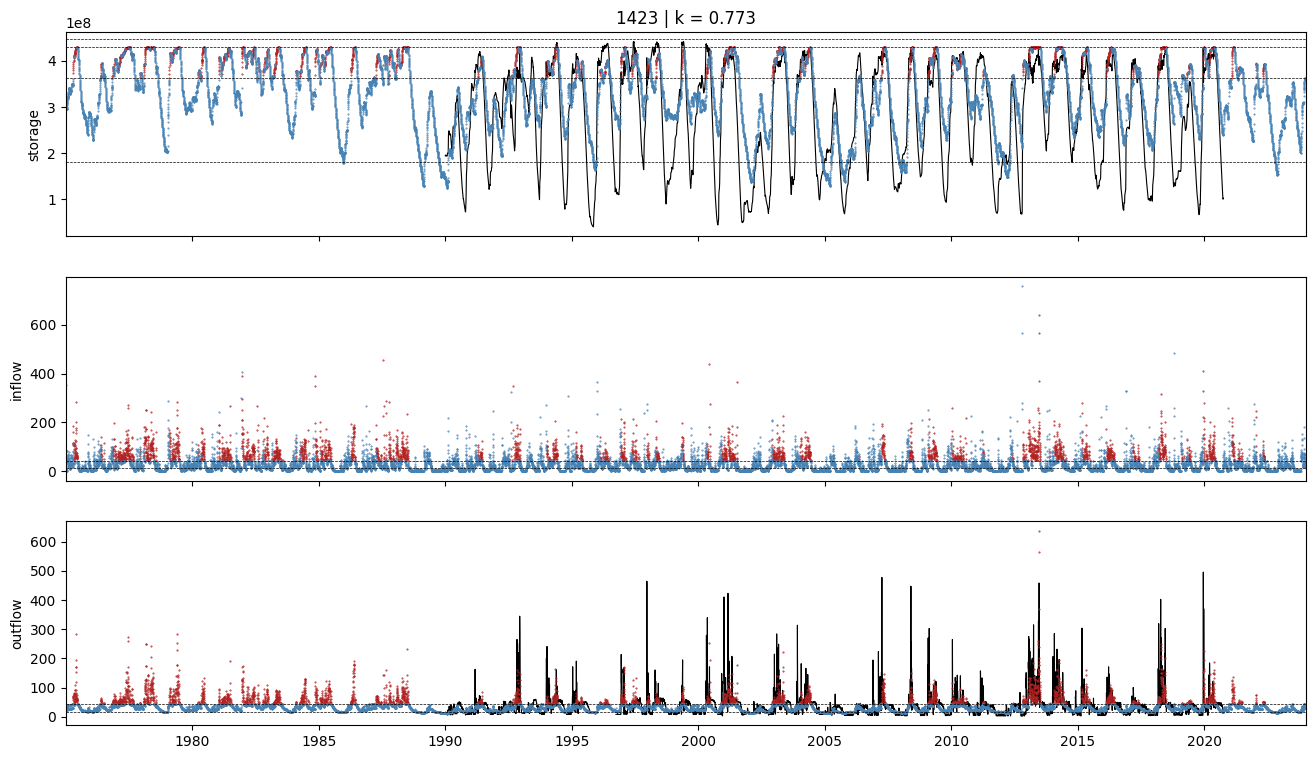

In [139]:
for gdw_id, sim in tqdm(sim_lisflood.items(), desc='reservoirs'):

    # extract reservoir characteristics
    cap_cm, catch_sm, area_sm = reservoirs.loc[gdw_id, ['CAP_MCM', 'CATCH_SKM', 'AREA_SKM']] * 1e6
    # extract inflow characteristics
    Qmin, Qn, Q100 = reservoirs.loc[gdw_id, ['DISENV_CMS', 'DISAVG_CMS', 'DIS100_CMS']]
    # extract reservoir parameters
    par_Vf, par_Qf = reservoirs.loc[gdw_id, ['flood_stor', 'outflow_fa']]

    k = max(1 - 5 * (cap_cm - Vf) / catch_sm, 0)
    print(f'{gdw_id}\tk = {k:.3f}')

    # define reservoir limits
    Vf = par_Vf * cap_cm
    Ve = cap_cm * (0.8 + 0.2 * par_Vf)
    Qf = Q100 * par_Qf

    year_start, year_end = reservoirs.loc[gdw_id, ['YEAR_DAM', 'REM_YEAR']]

    
    fig, axes = plt.subplots(nrows=3, figsize=(16, 9), sharex=True)
    
    flood_mode = (sim.storage > Vf) & (sim.inflow > Qf)
    
    for ax, var in zip(axes, ['storage', 'inflow', 'outflow']):
        ax.scatter(
            sim[flood_mode].index, 
            sim.loc[flood_mode, var], 
            marker='.', 
            s=.8, 
            color='firebrick')
        ax.scatter(
            sim[~flood_mode].index, 
            sim.loc[~flood_mode, var], 
            marker='.', 
            s=.8, 
            color='steelblue'
        )
        if var in ['storage', 'outflow']:
            ax.plot(obs[gdw_id][var], lw=.8, c='k', zorder=0)
        ax.set_ylabel(var)
        
    for y in [0.5 * Vf, Vf, Ve, cap_cm]:
        axes[0].axhline(y, ls='--', c='k', lw=.5)
    start = max(datetime(int(year_start), 1, 1), sim.first_valid_index()) if year_start else sim.first_valid_index()
    end = min(datetime(int(year_end), 12, 31), sim.last_valid_index()) if year_end else sim.last_valid_index()
    ax.set_xlim(start, end)
    
    for y in [0.5 * Qn, Qf]:
        axes[1].axhline(y, ls='--', c='k', lw=.5)
        axes[2].axhline(y, ls='--', c='k', lw=.5)
    
    axes[0].set_title(f'{gdw_id} | k = {k:.3f}');
    
    plt.savefig(path_plots / f'{gdw_id}_timeseries.jpg', dpi=300, bbox_inches='tight')

In [137]:
year_start, year_end

(np.float64(1945.0), None)

In [127]:
reservoirs.loc[gdw_ids, 'parameters']

1407     estimated
1410    calibrated
1423    calibrated
Name: parameters, dtype: object

In [130]:
cap_cm, catch_sm = reservoirs.loc[1410, ['CAP_MCM', 'CATCH_SKM']] * 1e6
cap_cm, catch_sm

(np.float64(586000000.0), np.float64(497000000.0))

0

In [112]:
cap_cm, Vf, catch_sm

(np.float64(446900000.0), np.float64(362793420.0), np.float64(2186000000.0))

In [116]:
(cap_cm - Vf) / catch_sm

np.float64(0.03847510521500457)

In [115]:
catch_sm

np.float64(2186000000.0)

In [123]:
cap_mcm, catch_skm, area_skm = reservoirs.loc[gdw_id, ['CAP_MCM', 'CATCH_SKM', 'AREA_SKM']].values

In [124]:
cap_mcm

np.float64(446.9)